In [7]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier
from matplotlib import pyplot as plt
import string
import math
import nltk

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Считаем данные из файла

In [2]:
data_path = 'ham-spam.csv'
data = pd.read_csv(data_path)
X = data['msg']
Y = data['target']

### Описание класса Наивного Байесовского классификатора

In [3]:
class NaiveBayes(object):
    """
    Наивный байесовский классификатор.
    Для каждого входного сообщения слово учитывается один раз при расчете итоговой вероятности.

    Parameters
    ----------
    category_priors : default | None, optional, default None
        Априорные вероятности категорий.
        Если None, то классификатор должен сам их вычислить.

    weight : float, optional, default 1
        Вес одного слова в формуле взвешенной вероятности

    supposed_prob : float, optional, default 0.5
        Предполагаемая вероятность слова в категории
    """

    def __init__(self, category_priors=None, weight=1, supposed_prob=0.5):
        self.category_priors = category_priors
        self.weight = weight
        self.supposed_prob = supposed_prob
        
        self.categories = []
        
        # Количество отдельных слов в заданной категории
        self.feature_category_counts = defaultdict(lambda: defaultdict(int))
        
        # Количество всех документов в данной категории ++++++++
        self.category_doc_counts = defaultdict(int)
        
        # Количество встреч слова во всех сообщениях
        self.feature_counts = defaultdict(int)
        
        #Предпосчитанные средневзешенные вероятности для слов из корпуса
        self.weighted_feature_probs = defaultdict(lambda: defaultdict(float))
        
        #Общее число слов в каждой из категорий
        self.category_total_feature_count = defaultdict(int)
            
            
    def fit(self, x_train, y_train):
        """
        Производит обучение наивного байесовского классификатора.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        y_train : list of str
            содержит список меток (названий категорий) для сообщений из x_train

        Returns
        -------
        self : object
            Returns self
        """
        # Подсчитываем количество категорий, документов и слов в каждой категории
        # и количество встреч слова во всех сообщениях
        
        count_categories = y_train.nunique()
        for cat in y_train.unique():
            self.categories.append(cat)
            
        for cat in y_train:
            self.category_doc_counts[cat] += 1
            
    
        translator = str.maketrans('', '', string.punctuation)
        for massege, label in zip(x_train, y_train):
            massege = massege.translate(translator)
            words = massege.split()
            cat = label
            for word in words:
                self.category_total_feature_count[cat] += 1
                self.feature_counts[word] += 1
                self.feature_category_counts[cat][word] += 1
            
        if self.category_priors == None:
            self.category_priors = defaultdict(float)
            total_docs = y_train.count()
            for cat in self.categories:
                self.category_priors[cat] = self.category_doc_counts[cat] / total_docs
            
        
        for cat in self.categories:
            for key in self.feature_category_counts[cat].keys():
                temp_prob = self.feature_category_counts[cat][key] / self.category_total_feature_count[cat]
                self.weighted_feature_probs[cat][key] += (self.weight * self.supposed_prob + \
                                                     self.feature_counts[key] * temp_prob)
                self.weighted_feature_probs[cat][key] /= (self.feature_counts[key] + self.weight)
                
        
        return self
    
    
    def get_weighted_feature_prob(self, cat, feature):
        """
        Вычисляет взвешенную вероятность P(Слово|Категория).

        Parameters
        ----------
        cat : str
            Название категории.

        feature : str
            Слово из текста.

        Returns
        -------
        prob : float
            Возвращает взвешенную вероятность слова feature при условии категории cat.
        """
        if self.weighted_feature_probs[cat][feature] != 0:
            prob = self.weighted_feature_probs[cat][feature]
        else:
            temp_prob = 1 / self.category_total_feature_count[cat]
            prob = self.weight * self.supposed_prob + self.feature_counts[feature] * temp_prob
            prob /= (self.feature_counts[feature] + self.weight)

        return prob
    
    
    def get_category_prob(self, cat, text):
        """
        Считает логарифм вероятность принадлежности сообщения text к категории cat.

        Parameters
        ----------
        cat : str
            Название категории.

        text : list of str
            Список из слов.

        Returns
        -------
        log_prob : float
            Возвращает логарифм вероятности категории cat для текста text.
        """
        log_prob = math.log(self.category_priors[cat])
        for feature in text:
            log_prob += math.log(self.get_weighted_feature_prob(cat, feature))
            
        return log_prob
    
    def get_probs(self, text):
        """
        Считает вероятности принадлежности текста (text) к каждой из категорий

        Parameters
        ----------
        text : list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.

        Returns
        -------
        probs : list of float
            Возвращает вероятности probs всех категорий для текста text
            в порядке их следования в self.category_doc_counts.
        """
        # Токенизируем текст, если это необходимо
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)
        text = text.split()
        
        probs = []
        for cat in self.categories:
            probs.append(self.get_category_prob(cat, text))

        return probs
    
    def predict(self, text):
        """
        Предсказывает метки категорий для text.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        Returns
        -------
        categories : list of str ??????????!!!?!??!?!
            Возвращает названия категорий для text.
        """
        categories = []
        if type(text) == type(list()):
            for massege in text:
                probs = self.get_probs(massege)
                categories.append(self.categories[probs.index(max(probs))])
        else:
            probs = self.get_probs(text)
            categories.append(self.categories[probs.index(max(probs))])
        return categories
    
    def score(self, text, labels):
        """
        Возвращает точность предсказаний на text для правильных категорий labels.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.
        labels : list of str
            Список категорий для каждого токена из text.

        Returns
        -------
        acc : float
            Точность предсказания.
        """
        acc = 0
        if type(text) == type(list()) or type(text) == type(pd.core.series.Series()):
            predictions = self.predict(list(text))
            for index, label in enumerate(labels):
                if predictions[index] == label:
                    acc += 1
            acc /= len(labels)
        else:
            if self.predict(text)[0] == labels:
                return 1
            else:
                return 0
        return acc

### Протестируем полученную модель, разбив исходных датасет на 10 фолдов. Проведем кросс-валидацию на этих фолдах.

In [4]:
model = NaiveBayes()
my_accuracy = []
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model.fit(x_train, y_train)
    my_accuracy.append(model.score(x_test, y_test))
    print('done')

print(my_accuracy)
my_mean_acc = sum(my_accuracy) / len(my_accuracy)

print('mean_acc =', my_mean_acc)

done
done
done
done
done
done
done
done
done
done
[0.8241379310344827, 0.9172413793103448, 0.9275862068965517, 0.9273356401384083, 0.8858131487889274, 0.9307958477508651, 0.9204152249134948, 0.9273356401384083, 0.9100346020761245, 0.9377162629757786]
mean_acc = 0.9108411884023384


### Теперь протестируем классификатор из модуля nltk на тех же фолдах, подготовив сначала входные данные.

In [5]:
translator = str.maketrans('', '', string.punctuation)

nltk_accuracy = []
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    #Формируем тренировочные и тестовые сеты для nltk.NaiveBayesClassifier
    train_set = []
    test_set = []
    for msg, label in zip(x_train, y_train):
        d = defaultdict(int)
        msg = msg.translate(translator)
        msg = msg.split()
        for word in msg:
            d[word] += 1
        train_set.append((d, label))
    for msg, label in zip(x_test, y_test):
        d = defaultdict(int)
        msg = msg.translate(translator)
        msg = msg.split()
        for word in msg:
            d[word] += 1
        test_set.append(d)
    #Тренируем и запускаем на встроенном классификаторе
    nltk_model = NaiveBayesClassifier.train(train_set)
    predicted_labels = nltk_model.classify_many(test_set)
    
    #Считаем получившуюся точность
    acc = 0
    for pred_label, label in zip(predicted_labels, y_test):
        if pred_label == label:
            acc += 1
    acc /= len(y_test)
    nltk_accuracy.append(acc)
    print('done')
    
print(nltk_accuracy)
nltk_mean_acc = sum(nltk_accuracy) / len(nltk_accuracy)
print('mean_acc =', nltk_mean_acc)

done
done
done
done
done
done
done
done
done
done
[0.9620689655172414, 0.9655172413793104, 0.9620689655172414, 0.9792387543252595, 0.9653979238754326, 0.9619377162629758, 0.9688581314878892, 0.9826989619377162, 0.9619377162629758, 0.9515570934256056]
mean_acc = 0.9661281469991648


### Построим графики размаха(ящики с усами) для двух классификаторов.

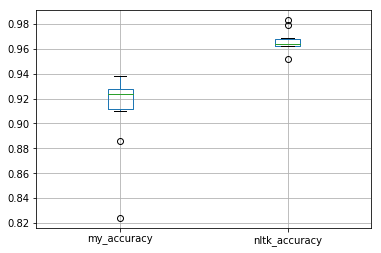

In [6]:
dframe = {'my_accuracy': my_accuracy, 'nltk_accuracy': nltk_accuracy}
dframe = pd.DataFrame(data=dframe)
dframe.boxplot()
pyplot.show()